In [1]:
from torchvision.models import resnet101, ResNet101_Weights
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
# set model

weights = ResNet101_Weights.IMAGENET1K_V1
model = resnet101(weights=weights)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to C:\Users\Night/.cache\torch\hub\checkpoints\resnet101-63fe2227.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
# set transforms

transforms_custom = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [4]:
with open("../data/imagenet_classes.txt", "r") as imgnet_cls:
    imgnet_cls_data = imgnet_cls.readlines()
    
cls_dict = {}

for data in imgnet_cls_data:
    dat_key, dat_val = data.split(":")
    dat_val = dat_val.strip().replace("'", "")
    if dat_val[-1] == ",":
        dat_val = dat_val[:-1]
    
    cls_dict[int(dat_key.strip())] = dat_val.strip()

In [5]:
cls_dict[0]

'tench, Tinca tinca'

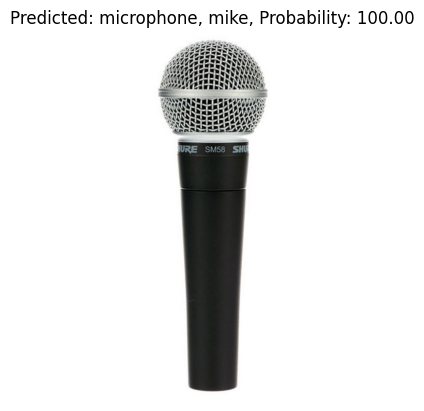

In [6]:
# check model working

image_path = "../data/imgs/mic.jpg"
image = Image.open(image_path)

image_tensor = transforms_custom(image)
image_tensor = image_tensor.unsqueeze(0).to(device)

with torch.inference_mode():
    output = model(image_tensor)
    
probs = torch.softmax(output, dim=1)

target_label_name = cls_dict[torch.argmax(probs, dim=1).item()]

plt.imshow(image)
plt.axis("off")
plt.title(f"Predicted: {target_label_name}, Probability: {probs.max()*100:.2f}")
plt.show();

# ONNX

In [8]:
dummy_import = torch.randn(1, 3, 224, 224, device=device)
onnx_model_path = "../models/resnet101.onnx"

with torch.inference_mode():
    torch.onnx.export(
        model,
        dummy_import,                         
        onnx_model_path,
        export_params=True,
        opset_version=14,
        do_constant_folding=True,
        input_names = ['input'],
        output_names = ['output'],
        dynamic_axes={'input' : {0 : 'batch_size'}, 'output' : {0 : 'batch_size'}}
    )
    
print("[INFO] Done!")

[INFO] Done!
